# Python Project - Samuele Ceol 
A case study on the correlation between the labour market and suicide rates in Europe

TODO - Flag codes?

In [525]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns

In [518]:
euro_countries = ['Russian Federation','Ukraine','France','Spain','Sweden','Norway','Germany','Finland','Poland','Italy','United Kingdom','Romania','Belarus','Kazakhstan','Greece','Bulgaria','Iceland','Hungary','Portugal','Austria','Czechia','Serbia','Ireland','Lithuania','Latvia','Croatia','Bosnia and Herzegovina','Slovakia','Estonia','Denmark','Switzerland','Netherlands','Moldova','Belgium','Armenia','Albania','North Macedonia','Turkey','Slovenia','Montenegro','Kosovo','Azerbaijan','Cyprus','Luxembourg','Georgia','Andorra','Malta','Liechtenstein','San Marino','Monaco','Vatican City']

def OECD_prepare_data(data, value, drop_sex=True):
    # Drop unused columns
    drop_columns = ['INDICATOR', 'MEASURE', 'FREQUENCY', 'Flag Codes']

    if(drop_sex == True):
        drop_columns = np.append(drop_columns, 'SUBJECT')

    data = data.drop(drop_columns, axis=1)

    # Rename columns
    if(drop_sex == True):
        data.columns = ['country', 'year', value]
    else:
        data.columns = ['country', 'sex', 'year', value]

    # Modify sex column content
    if(drop_sex == False):
        data['sex'] = data['sex'].replace('TOT', 'total').replace('MEN', 'male').replace('WOMEN', 'female')

    return data

# OECD Data - Description

For the OECD we have three distinct files, one for males, one for females and one aggregate (M/F).

The dataset contains only data related to european countries.

No age group distinction is provided.

The column LOCATION identifies the interested country with a unique three letter abbreviation.

Suicide rates are indicated as nr of suicides per 100.000 people.

In [459]:
suicide_tot = pd.read_csv('./source/OECD_suicides_total.csv')
suicide_male = pd.read_csv('./source/OECD_suicides_male.csv')
suicide_female = pd.read_csv('./source/OECD_suicides_female.csv')

In [460]:
suicide_tot.shape

(1955, 8)

In [461]:
suicide_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LOCATION    1955 non-null   object 
 1   INDICATOR   1955 non-null   object 
 2   SUBJECT     1955 non-null   object 
 3   MEASURE     1955 non-null   object 
 4   FREQUENCY   1955 non-null   object 
 5   TIME        1955 non-null   int64  
 6   Value       1955 non-null   float64
 7   Flag Codes  98 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 122.3+ KB


In [462]:
suicide_tot.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,SUICIDE,TOT,100000PER,A,1960,13.1,NaN
1,AUS,SUICIDE,TOT,100000PER,A,1961,14.5,NaN
2,AUS,SUICIDE,TOT,100000PER,A,1962,16.9,NaN
3,AUS,SUICIDE,TOT,100000PER,A,1963,19.2,NaN
4,AUS,SUICIDE,TOT,100000PER,A,1964,17.8,NaN


# OECD Data - Required actions

We would like to join this three different entities into a single dataframe.


In [463]:
OECD_suicide = pd.concat([suicide_tot, suicide_male, suicide_female])

We can then standardize the content of the SUBJECT column

We can discard the INDICATOR, SUBJECT, MEASURE and FREQUENCY columns since they are only descriptive and not needed for our analysis

We can rename the columns

In [466]:
OECD_suicide = OECD_prepare_data(OECD_suicide, 'suicides_no', False)

To join the OECD dataset with the one provided by the World Health Organization, we want to change the three letters identifiers to the full country names.
To do that, we use the pycountry library.

In [467]:
import pycountry

OECD_suicide['country'] = OECD_suicide['country'].apply(
    lambda x: pycountry.countries.get(alpha_3=x).name 
    if len(x) == 3 
    else pycountry.countries.get(alpha_2=x).name
)

We can now filter out the countries in the dataset that are not in (geographical) Europe

TODO - find out if there is a better way to get the list of european countries

In [468]:
print('Initial nr of countries: ')
print(OECD_suicide['country'].nunique())

OECD_suicide = OECD_suicide[OECD_suicide['country'].isin(euro_countries)]

print('Final nr of countries: ')
print(OECD_suicide['country'].nunique())

#List of european countries that are not present in this dataset
print('European countries not present in this dataset: ')
print([x for x in euro_countries if x not in OECD_suicide['country'].unique().tolist()])

Initial nr of countries: 
41
Final nr of countries: 
28
European countries not present in this dataset: 
['Ukraine', 'Romania', 'Belarus', 'Kazakhstan', 'Bulgaria', 'Serbia', 'Croatia', 'Bosnia and Herzegovina', 'Moldova', 'Armenia', 'Albania', 'North Macedonia', 'Montenegro', 'Kosovo', 'Azerbaijan', 'Cyprus', 'Georgia', 'Andorra', 'Malta', 'Liechtenstein', 'San Marino', 'Monaco', 'Vatican City']


We can finally rename the remaining columns and see how the dataframe looks like.

TODO - Maintain the groupby even though we don't have duplicates

In [469]:
OECD_suicide.head()

,country,sex,year,suicides_no
57,Austria,total,1960,24.2
58,Austria,total,1961,23.2
59,Austria,total,1962,23.8
60,Austria,total,1963,23.0
61,Austria,total,1964,24.1


In [470]:
OECD_suicide = OECD_suicide.sort_values(['country', 'year','sex']).reset_index(drop = True)

In [471]:
OECD_suicide.head()

,country,sex,year,suicides_no
0,Austria,female,1960,14.7
1,Austria,male,1960,36.6
2,Austria,total,1960,24.2
3,Austria,female,1961,13.7
4,Austria,male,1961,35.5


In [472]:
OECD_suicide['country'].nunique()

28

# WHO Data - Description

For the data provided by the World Health Organization we have a single file containing data for males and females with a further division by age group.

Suicide values are stored as totals unlike the previous dataframe where they were stored in relation to nr of suicides per 100.000.

The dataframe also contains information related to the total population of the country in the given year.


In [473]:
WHO_suicide = pd.read_csv('./source/WHO_suicides_aggregate.csv')

In [474]:
WHO_suicide.shape

(43776, 6)

In [475]:
WHO_suicide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43776 entries, 0 to 43775
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      43776 non-null  object 
 1   year         43776 non-null  int64  
 2   sex          43776 non-null  object 
 3   age          43776 non-null  object 
 4   suicides_no  41520 non-null  float64
 5   population   38316 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.0+ MB


In [476]:
WHO_suicide.head()

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0


# WHO Data - Required actions

Just like for the OECD data, we filter out the countries that are not in Europe.

In [477]:
print('Initial nr of countries: ')
print(WHO_suicide['country'].nunique())

WHO_suicide = WHO_suicide[WHO_suicide['country'].isin(euro_countries)]

print('Final nr of countries: ')
print(WHO_suicide['country'].nunique())

#List of european countries that are not present in this dataset
print('European countries not present in this dataset: ')
print([x for x in euro_countries if x not in WHO_suicide['country'].unique().tolist()])

Initial nr of countries: 
141
Final nr of countries: 
44
European countries not present in this dataset: 
['Czechia', 'Moldova', 'North Macedonia', 'Kosovo', 'Andorra', 'Liechtenstein', 'Vatican City']


We can also drop the rows in which suicide data is not present.

In [478]:
WHO_suicide = WHO_suicide[WHO_suicide['suicides_no'].notna()]

For our analysis, we are not considering the differences between age groups.

Because of this reason, we can drop the 'age' column and sum population and suicide numbers.


In [479]:
WHO_suicide = WHO_suicide.drop('age', axis=1).groupby(['country', 'year', 'sex']).sum().unstack()

Since the dataframe only has a division between males and females, we want to add a new category for the total values which contains the sum for both nr of suicides between males and females and value of the total population.

To facilitate this process, we compute the totals for suicides numbers and population in two different variables and then merge them.

We then flatten the hierarchical index


In [480]:
WHO_suicide_mf      = WHO_suicide['suicides_no'].assign(total=WHO_suicide['suicides_no'].sum(1)).stack(level='sex')
WHO_population_mf   = WHO_suicide['population'].assign(total=WHO_suicide['population'].sum(1)).stack(level='sex')

WHO_suicide = pd.DataFrame(
    pd.concat(
        [WHO_suicide_mf, WHO_population_mf], 
        axis=1
    ).to_records()).rename(columns = {'0':'suicides_no', '1':'population'}
) 

Before converting the suicide nr to suicide rates, we should first address the few rows with missing population data.

My initial idea was to use The World Bank census data in order to fill in the gaps in the poulation numbers for the WHO dataset

The following (now commented) code, was used to drop the columns were not needed, pivot longer the year columns and filter out the non european countries.

In [481]:
'''
census_tot      = pd.read_csv('./source/census_total.csv').drop(['Country Code', 'Indicator Code'], axis=1)
census_male     = pd.read_csv('./source/census_male.csv').drop(['Country Code', 'Indicator Code'], axis=1)
census_female   = pd.read_csv('./source/census_female.csv').drop(['Country Code', 'Indicator Code'], axis=1)

census = pd.concat([census_tot, census_male, census_female])

census = pd.melt(
    census, 
    id_vars = ['Country Name', 'Indicator Name'], 
    value_vars = [str(i).zfill(4) for i in range(1960,2020)], 
    var_name='year', 
    value_name='population'
).sort_values(
    ['Country Name', 'year', 'Indicator Name']
)

census = census[census['Country Name'].isin(euro_countries)]
census
'''

"\ncensus_tot      = pd.read_csv('./source/census_total.csv').drop(['Country Code', 'Indicator Code'], axis=1)\ncensus_male     = pd.read_csv('./source/census_male.csv').drop(['Country Code', 'Indicator Code'], axis=1)\ncensus_female   = pd.read_csv('./source/census_female.csv').drop(['Country Code', 'Indicator Code'], axis=1)\n\ncensus = pd.concat([census_tot, census_male, census_female])\n\ncensus = pd.melt(\n    census, \n    id_vars = ['Country Name', 'Indicator Name'], \n    value_vars = [str(i).zfill(4) for i in range(1960,2020)], \n    var_name='year', \n    value_name='population'\n).sort_values(\n    ['Country Name', 'year', 'Indicator Name']\n)\n\ncensus = census[census['Country Name'].isin(euro_countries)]\ncensus\n"

This solution was not implemented because I later realized that:

    - Only 9 rows, out of the total 3759, were missing this data
    - The two interested countries (Monaco and San Marino) were missing this data also in the other datasets

Given the small amount of interested rows, we can drop them without compromising the value of our data.

In [482]:
WHO_suicide = WHO_suicide[WHO_suicide['population'] != 0]

We can now convert the suicide values to suicides per 100.000 and then drop the population column.

Suicide rate = (Nr of suicides / population) * 100.000

In [483]:
WHO_suicide['suicides_no'] = ((WHO_suicide['suicides_no'] / WHO_suicide['population']) * 100000).round(1)
WHO_suicide = WHO_suicide.drop('population', axis=1)

In [484]:
WHO_suicide.head()

,country,year,sex,suicides_no
0,Albania,1987,female,1.9
1,Albania,1987,male,3.4
2,Albania,1987,total,2.7
3,Albania,1988,female,1.6
4,Albania,1988,male,2.9


# Suicide data - Merging the two datasets

We are now ready to combine the data coming from the two datasets

In case we have rows with the same country, year and sex, we keep the OECD data (which was already provided in the format of suicides per 100.000 people)

In [485]:
suicide = pd.concat([OECD_suicide, WHO_suicide]).drop_duplicates(subset=['country', 'year', 'sex'], keep='first').sort_values(['country', 'year','sex']).reset_index(drop=True)

print('Shape of OECD data: ' + str(OECD_suicide.shape))
print('Shape of WHO data: ' + str(WHO_suicide.shape))
print('Shape of final suicide dataset: ' + str(suicide.shape))

Shape of OECD data: (4002, 4)
Shape of WHO data: (3750, 4)
Shape of final suicide dataset: (5187, 4)


In [486]:
suicide

,country,sex,year,suicides_no
0,Albania,female,1987,1.9
1,Albania,male,1987,3.4
2,Albania,total,1987,2.7
3,Albania,female,1988,1.6
4,Albania,male,1988,2.9
...,...,...,...,...
5182,United Kingdom,male,2015,11.6
5183,United Kingdom,total,2015,7.5
5184,United Kingdom,female,2016,3.3
5185,United Kingdom,male,2016,11.4


# OECD Labour Market Data - Description

Unemployment rates (m/f)

Long-term Unemployment rates (total - % of Unemployment - unemployed for 12 months or more - 1968-2019)

Labour compensation per hour worker (tot - 1970-2019)

Hours worked - (tot - 1950-2019)

Tax wedge (tot - 2000-2019)

Pension spending (public/private - on % of GDP - 1980-2019)

Public Unemployment spending (total - on % of GDP - 1980-2019)

In [487]:
unemployment_rates = OECD_prepare_data(pd.read_csv('./source/labour/OECD_unemployment.csv'), 'unemployment_rates', False)
long_term_un = OECD_prepare_data(pd.read_csv('./source/labour/OECD_longTermUnemployment.csv'), 'long_term_unemployment')
compensation = OECD_prepare_data(pd.read_csv('./source/labour/OECD_compensation.csv'), 'compensation')
hours = OECD_prepare_data(pd.read_csv('./source/labour/OECD_hours.csv'), 'hours_worked')
tax_wedge = OECD_prepare_data(pd.read_csv('./source/labour/OECD_taxWedge.csv'), 'tax_wedge')
pension = OECD_prepare_data(pd.read_csv('./source/labour/OECD_pension.csv'), 'pension_spending')
unempl_spending = OECD_prepare_data(pd.read_csv('./source/labour/OECD_unemploymentSPending.csv'), 'unemployment_spending')

TODO - See what we lose on merge based on shape

In [488]:
join_columns = ['country', 'year']

labour = unemployment_rates.merge(
    long_term_un,
    on = join_columns
).merge(
    compensation,
    on = join_columns
).merge(
    hours,
    on = join_columns
).merge(
    tax_wedge,
    on = join_columns
).merge(
    unempl_spending,
    on = join_columns
)

In [489]:
labour['country'] = labour['country'].apply(
    lambda x: pycountry.countries.get(alpha_3=x).name 
    if len(x) == 3 
    else pycountry.countries.get(alpha_2=x).name
)

In [490]:
labour = labour[labour['country'].isin(euro_countries)]

In [496]:
merged_data = suicide.merge(
    labour,
    on = ['country', 'sex', 'year']
)

final

,country,sex,year,suicides_no,unemployment_rates,long_term_unemployment,compensation,hours_worked,tax_wedge,unemployment_spending
0,Austria,female,2000,9.7,3.841161,25.837572,2.617126,1675.0,47.312048,0.922
1,Austria,male,2000,31.9,3.294462,25.837572,2.617126,1675.0,47.312048,0.922
2,Austria,total,2000,19.4,3.933333,25.837572,2.617126,1675.0,47.312048,0.922
3,Austria,female,2001,9.0,3.801925,23.331006,1.991982,1663.0,46.910884,0.909
4,Austria,male,2001,29.2,3.425509,23.331006,1.991982,1663.0,46.910884,0.909
...,...,...,...,...,...,...,...,...,...,...
1233,United Kingdom,male,2015,11.6,5.455402,30.668295,1.734254,1527.0,30.814131,0.171
1234,United Kingdom,total,2015,7.5,5.325000,30.668295,1.734254,1527.0,30.814131,0.171
1235,United Kingdom,female,2016,3.3,4.680531,27.188206,2.158352,1541.0,30.913017,0.157
1236,United Kingdom,male,2016,11.4,4.923618,27.188206,2.158352,1541.0,30.913017,0.157


In [500]:
c = merged_data[merged_data['sex'] == 'total'].corr()
c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False)


unemployment_rates      long_term_unemployment    0.550195
long_term_unemployment  hours_worked              0.547884
unemployment_rates      hours_worked              0.429486
tax_wedge               unemployment_spending     0.334735
suicides_no             compensation              0.332449
                        tax_wedge                 0.324634
long_term_unemployment  tax_wedge                 0.295730
unemployment_rates      unemployment_spending     0.211257
compensation            hours_worked              0.187589
suicides_no             long_term_unemployment    0.084854
long_term_unemployment  unemployment_spending     0.069829
year                    unemployment_rates        0.060166
unemployment_rates      tax_wedge                 0.055468
year                    unemployment_spending     0.031955
suicides_no             hours_worked              0.028531
                        unemployment_rates        0.026150
compensation            tax_wedge                 0.0081

<AxesSubplot:>

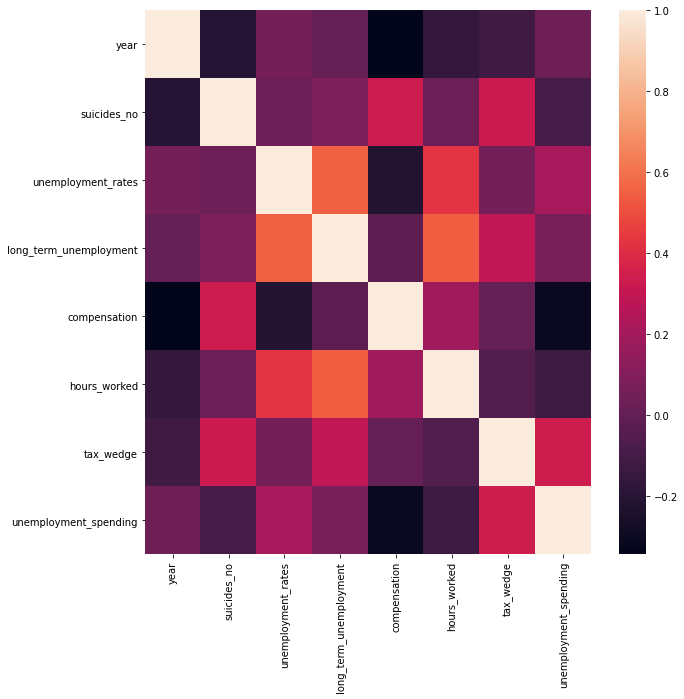

In [501]:
plt.figure(figsize=(10,10))
sns.heatmap(c)

# Machine Learning Models

## Train and test splits


In [504]:
y = merged_data.suicides_no # Target variable
X = merged_data.drop('suicides_no', axis=1) # Input features

In [526]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

ModuleNotFoundError: No module named 'sklearn'